In [1]:
from netCDF4 import Dataset
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from glob import glob
import pickle
import random
import os
import fnmatch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
import torch.nn.functional as F
from torchvision import datasets, transforms
from typing import Tuple, List, Type, Dict, Any
from torch.utils.tensorboard import SummaryWriter

from SGDR import CosineAnnealingWarmRestarts
from mish import Mish
from coord_conv import CoordConv
from MyResidualNetwork import MyResNet, MyBasicBlock
from MyDataPreparation import CustomDataset, Sampler
from autoencoder import Encoder, Decoder

In [2]:
def drawing(tensor1, tensor2, indexes):
    for i in indexes:
        extracted_tensor1_0 = tensor1[i, 0, :, :]
        extracted_tensor1_1 = tensor1[i, 1, :, :]
        extracted_tensor1_2 = tensor1[i, 2, :, :]
        extracted_tensor2_0 = tensor2[i, 0, :, :]
        extracted_tensor2_1 = tensor2[i, 1, :, :]
        extracted_tensor2_2 = tensor2[i, 2, :, :]

        array1_0 = extracted_tensor1_0.detach().cpu().numpy()
        array1_1 = extracted_tensor1_1.detach().cpu().numpy()
        array1_2 = extracted_tensor1_2.detach().cpu().numpy()
        array2_0 = extracted_tensor2_0.detach().cpu().numpy()
        array2_1 = extracted_tensor2_1.detach().cpu().numpy()
        array2_2 = extracted_tensor2_2.detach().cpu().numpy()

        vmin = min(array1_0.min(), array2_0.min())
        vmax = max(array1_0.max(), array2_0.max())

        fig, axs = plt.subplots(2, 3, figsize=(10, 5))

        cax1 = axs[0, 0].imshow(array1_0, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[0, 0].set_title('Sample adt')

        cax2 = axs[0, 1].imshow(array1_1, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[0, 1].set_title('Sample ugos')
        
        cax3 = axs[0, 2].imshow(array1_2, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[0, 2].set_title('Sample vgos')

        cax4 = axs[1, 0].imshow(array2_0, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title('Decoded adt')

        cax5 = axs[1, 1].imshow(array2_1, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[1, 1].set_title('Decoded ugos')

        cax6 = axs[1, 2].imshow(array2_2, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[1, 2].set_title('Decoded vgos')

        cbar = fig.colorbar(cax1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.ax.set_ylabel('adt')

        plt.tight_layout()
        plt.show()

        print('--------------------------------------------------------------------------------------------------')

In [3]:
run_name = 'adt_pre_autoencoder_run001'

In [4]:
device = torch.device('cuda:1')

In [5]:
encoder = torch.load(f'/app/Kara_plume_movement/adt/models/model_{run_name}_encoder.pth', map_location=torch.device('cpu'));
decoder = torch.load(f'/app/Kara_plume_movement/adt/models/model_{run_name}_decoder.pth', map_location=torch.device('cpu'));

/tmp/ipykernel_3402/2218876875.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load(f'/app/Kara_plume_movement/adt/models/model_{run_name}_encoder.pth', 

In [6]:
encoder.eval();
decoder.eval();

In [7]:
encoder = encoder.cuda()
decoder = decoder.cuda()

In [8]:
from adt_pre_autoencoder_001 import validate_single_epoch, find_files

In [9]:
data = Dataset('/mnt/hippocamp/asavin/data/ssh/adt_1993-2022_daily.nc', 'r')

In [10]:
batch_size = 32

In [11]:
dataset = CustomDataset(data=data, non_nan_threshold_value=700)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
data, mask = next(iter(dataloader))
data.shape, mask.shape

(torch.Size([32, 3, 40, 120]), torch.Size([32, 3, 40, 120]))

In [13]:
loss_function=torch.nn.MSELoss()

In [14]:
data_gpu = data.to(device='cuda', dtype=torch.float)
mask_gpu = mask.to(device='cuda', dtype=torch.float)
encoded_data = encoder.forward(data_gpu)
decoded_data = decoder.forward(encoded_data)
data_gpu_masked = data_gpu[mask_gpu == 1]
result_masked = decoded_data[mask_gpu == 1]
loss = loss_function(data_gpu_masked, result_masked)
test_loss = loss.detach() * batch_size

In [15]:
test_loss

tensor(0.1439, device='cuda:0')

/tmp/ipykernel_3402/725108594.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


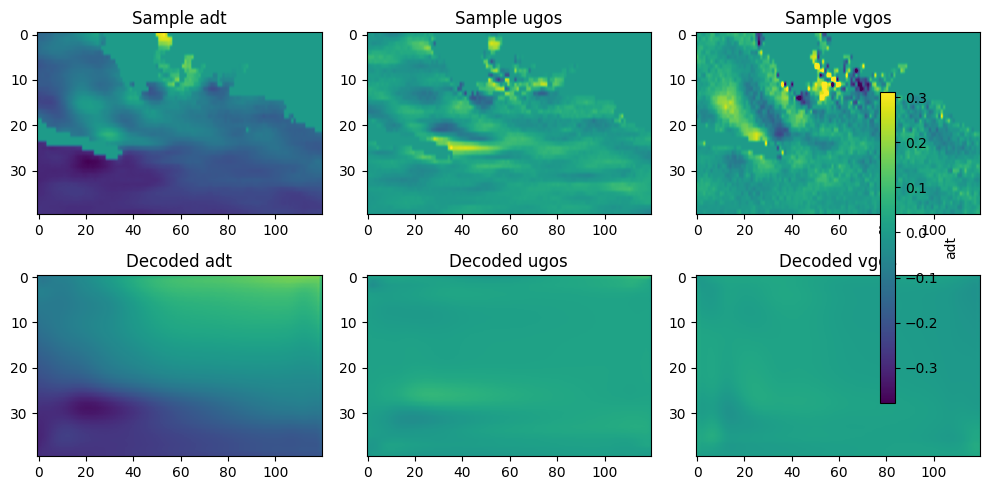

--------------------------------------------------------------------------------------------------


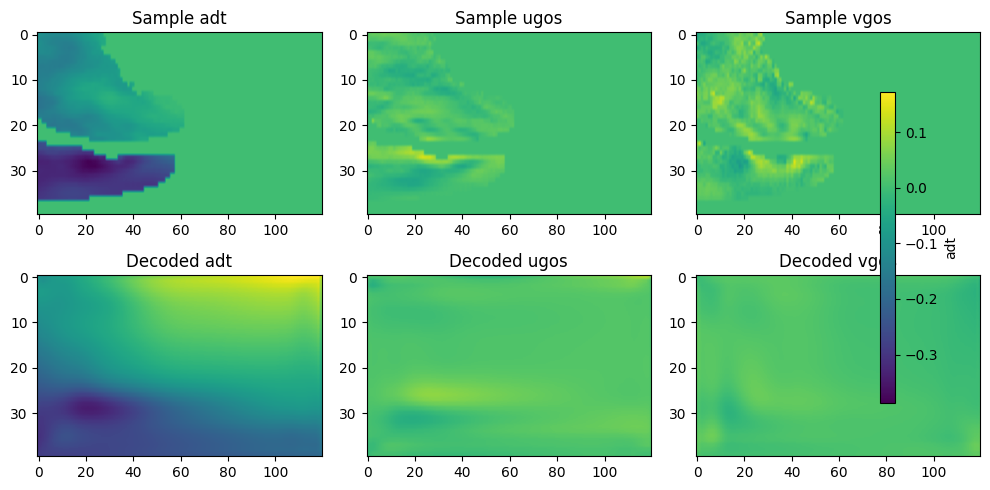

--------------------------------------------------------------------------------------------------


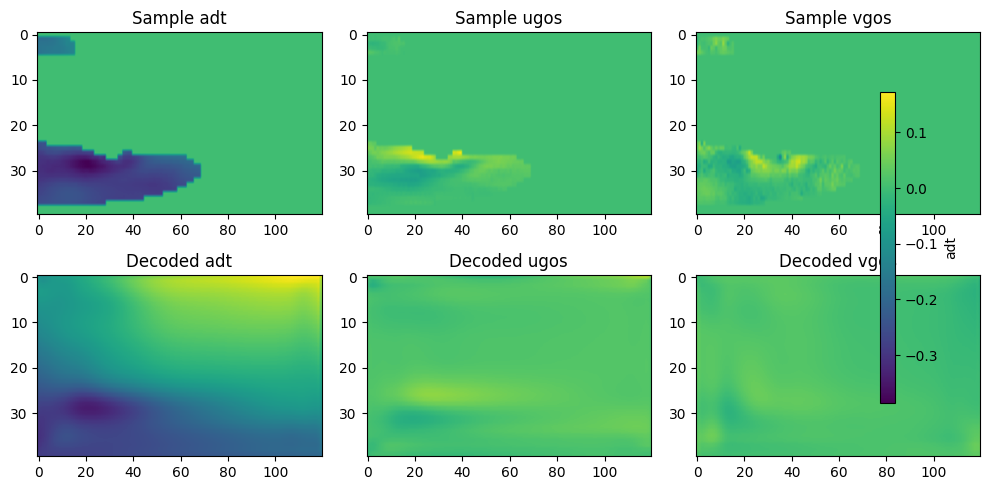

--------------------------------------------------------------------------------------------------


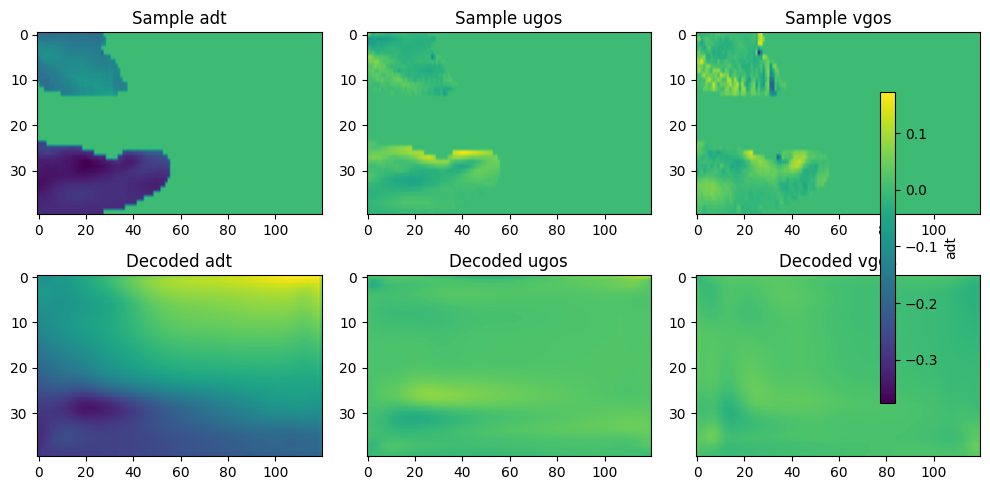

--------------------------------------------------------------------------------------------------


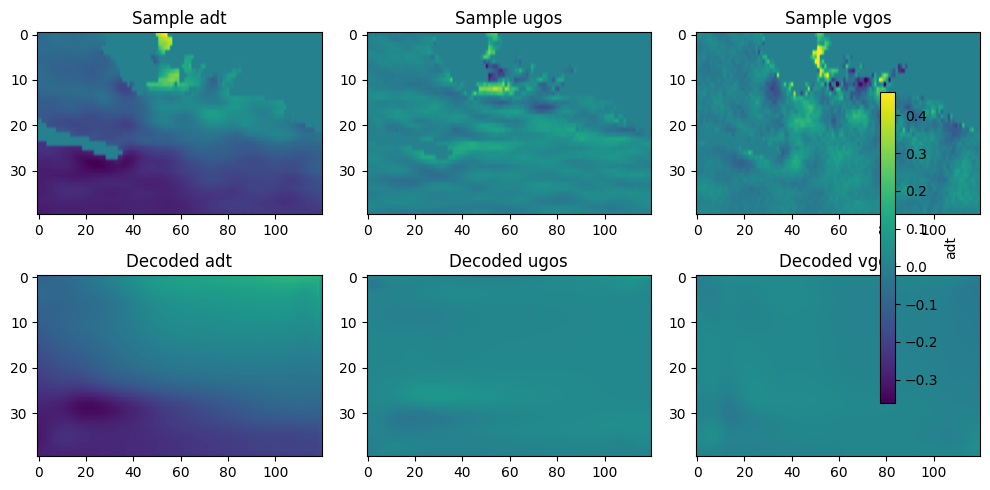

--------------------------------------------------------------------------------------------------


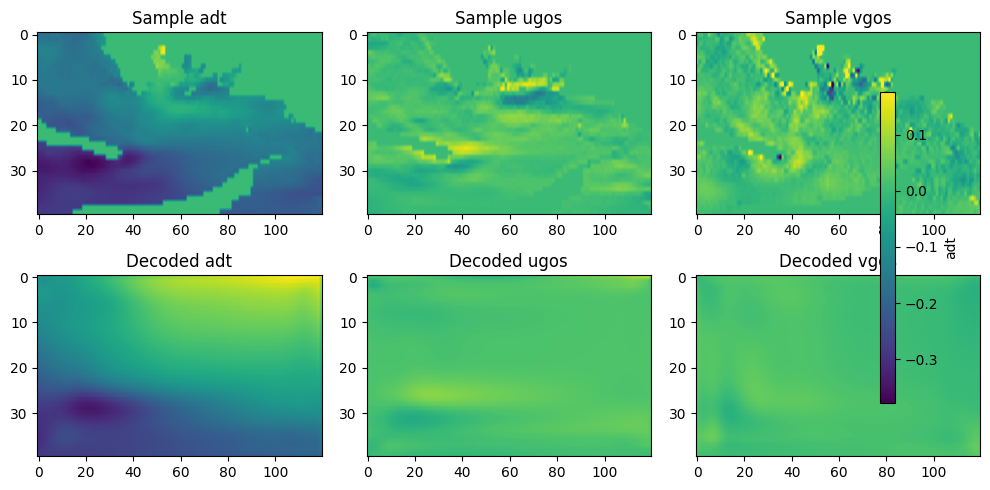

--------------------------------------------------------------------------------------------------


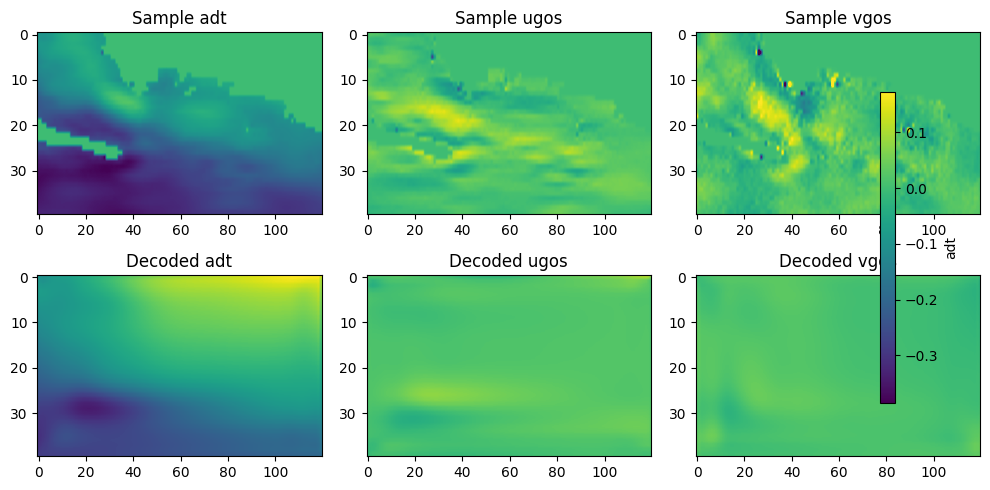

--------------------------------------------------------------------------------------------------


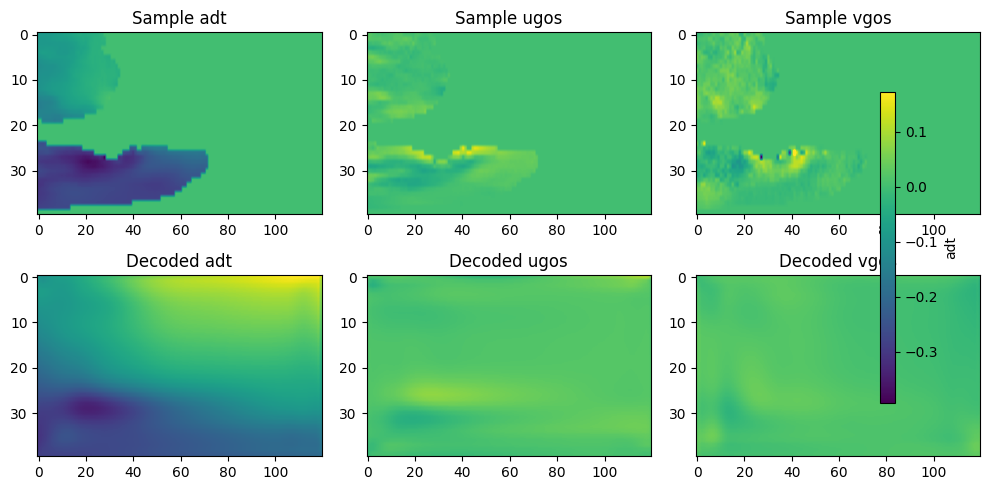

--------------------------------------------------------------------------------------------------


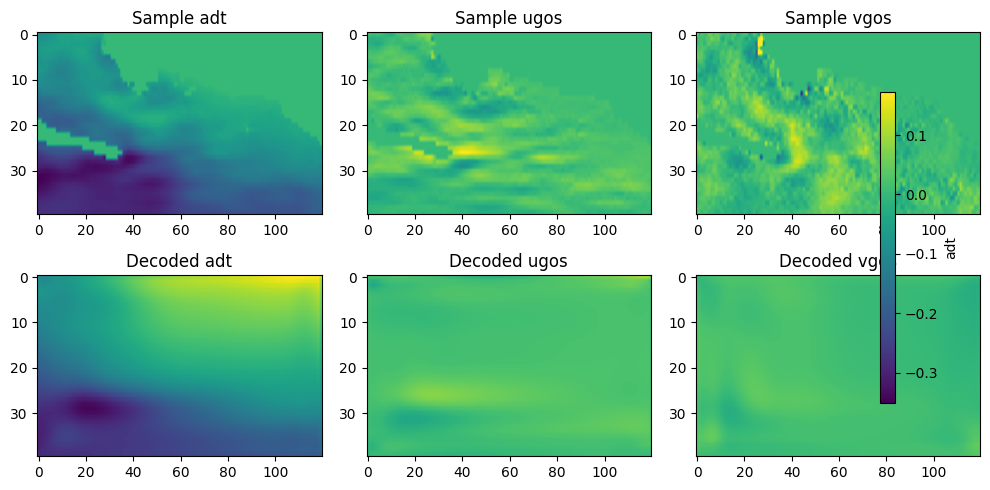

--------------------------------------------------------------------------------------------------


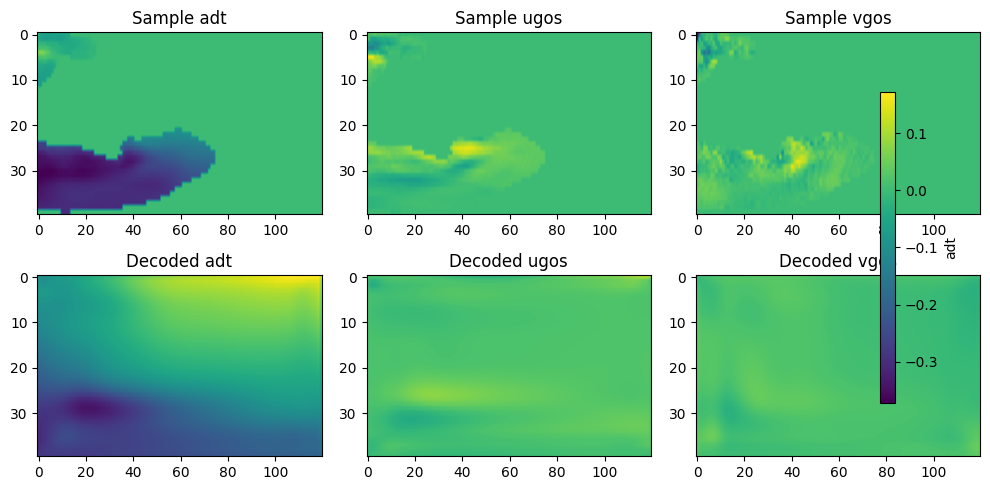

--------------------------------------------------------------------------------------------------


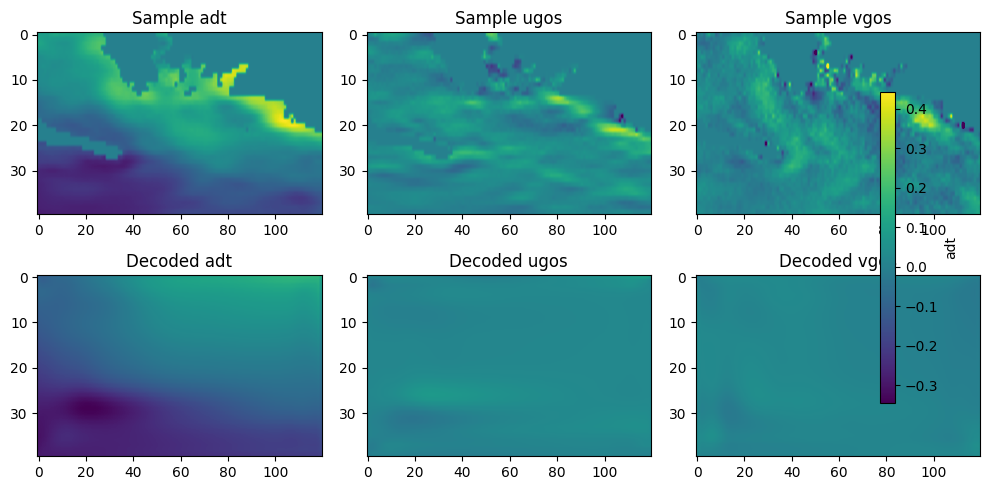

--------------------------------------------------------------------------------------------------


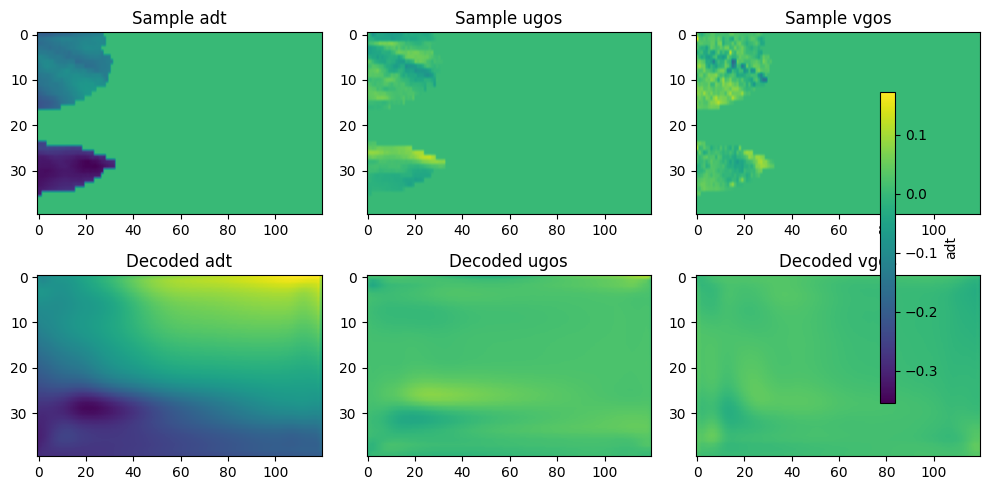

--------------------------------------------------------------------------------------------------


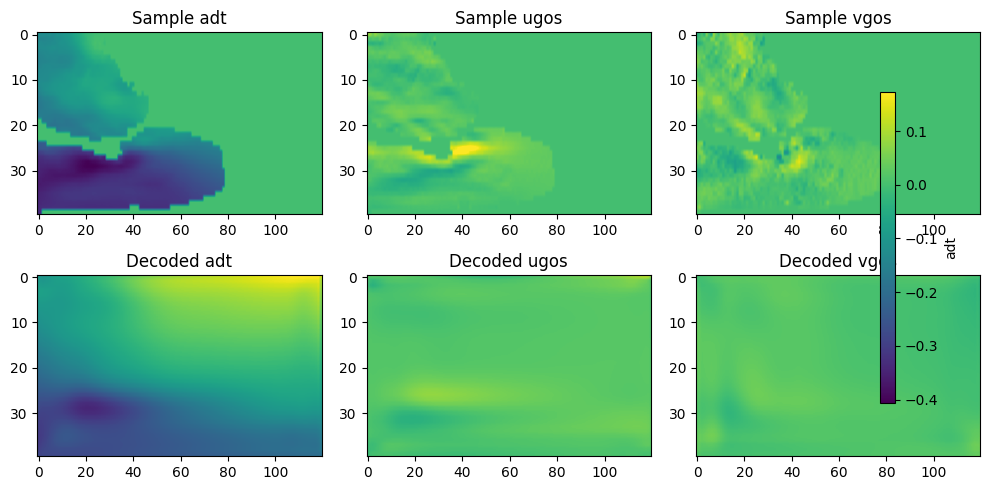

--------------------------------------------------------------------------------------------------


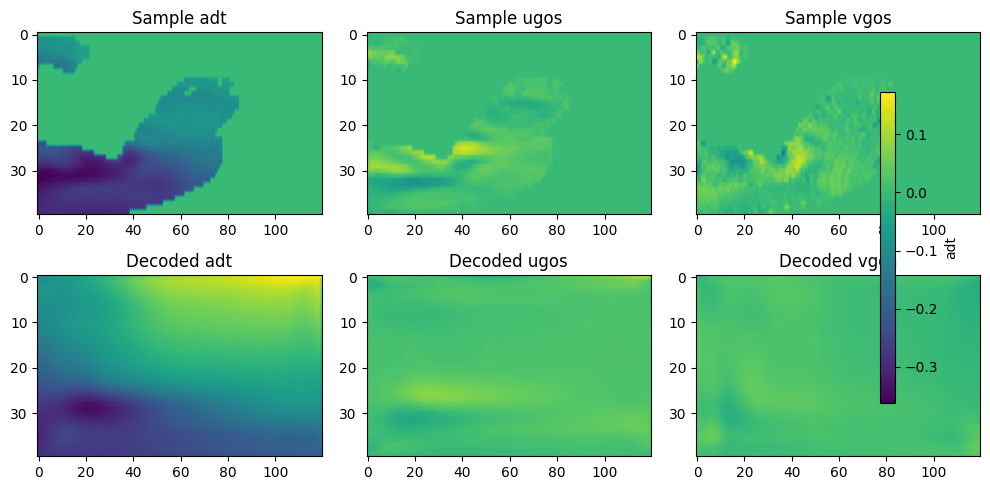

--------------------------------------------------------------------------------------------------


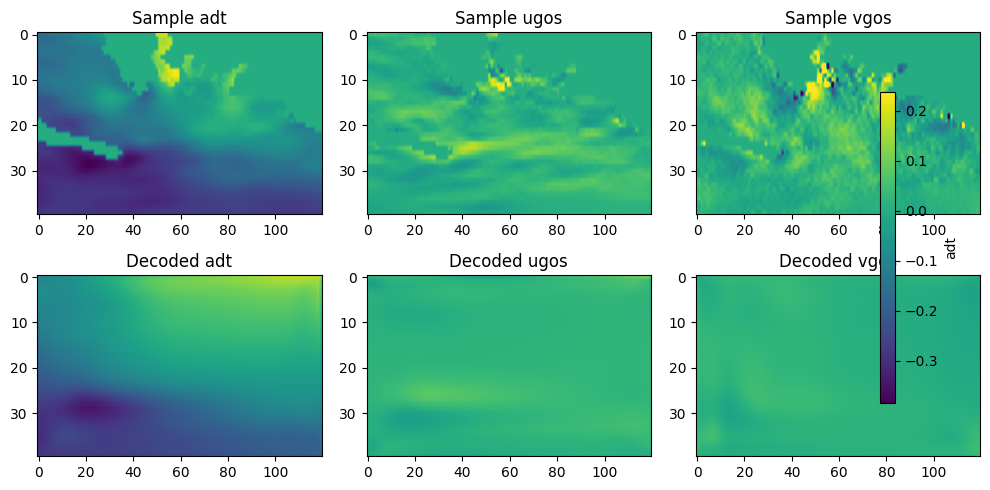

--------------------------------------------------------------------------------------------------


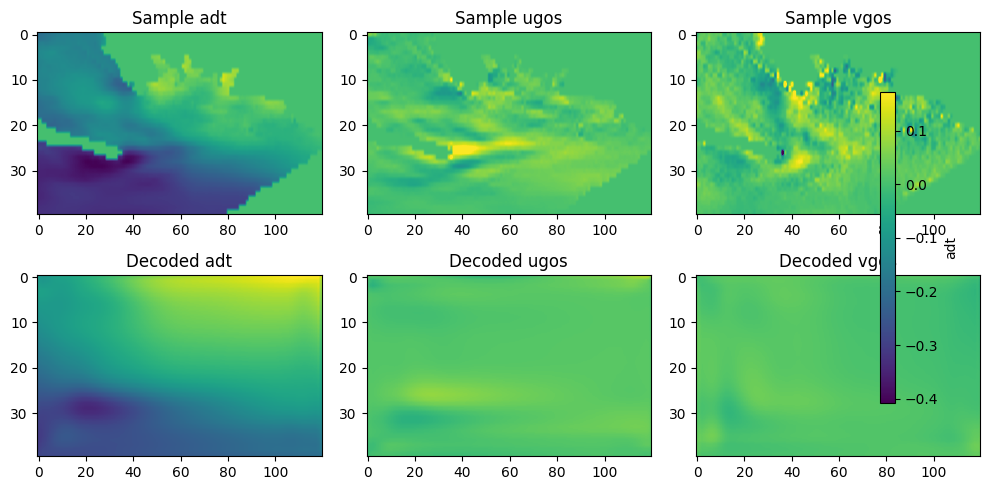

--------------------------------------------------------------------------------------------------


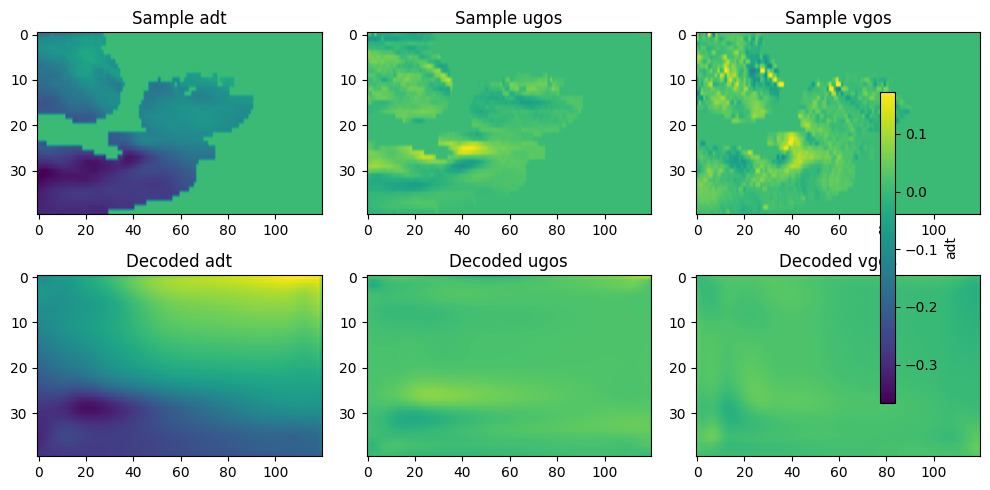

--------------------------------------------------------------------------------------------------


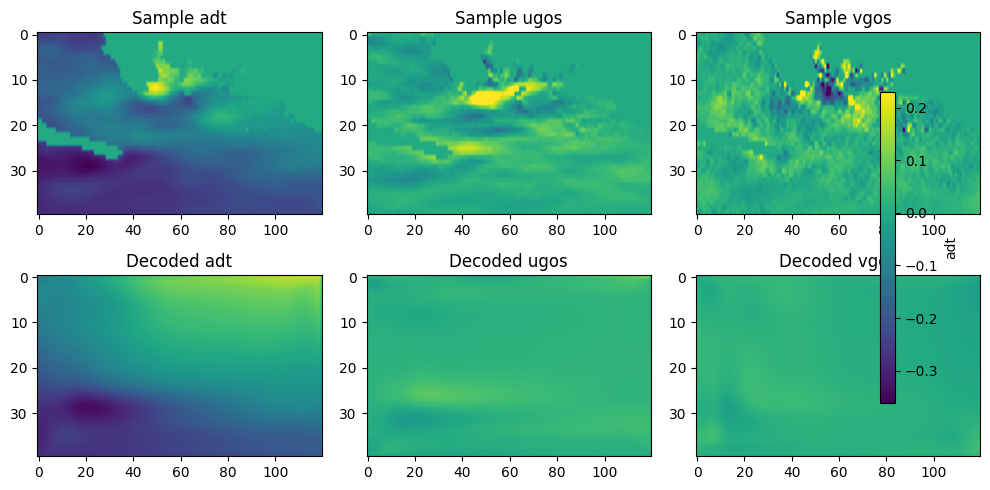

--------------------------------------------------------------------------------------------------


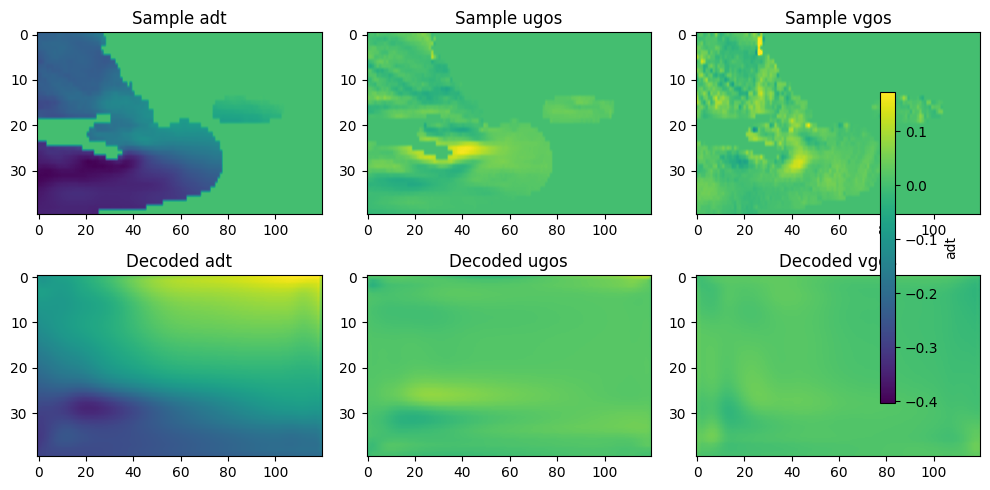

--------------------------------------------------------------------------------------------------


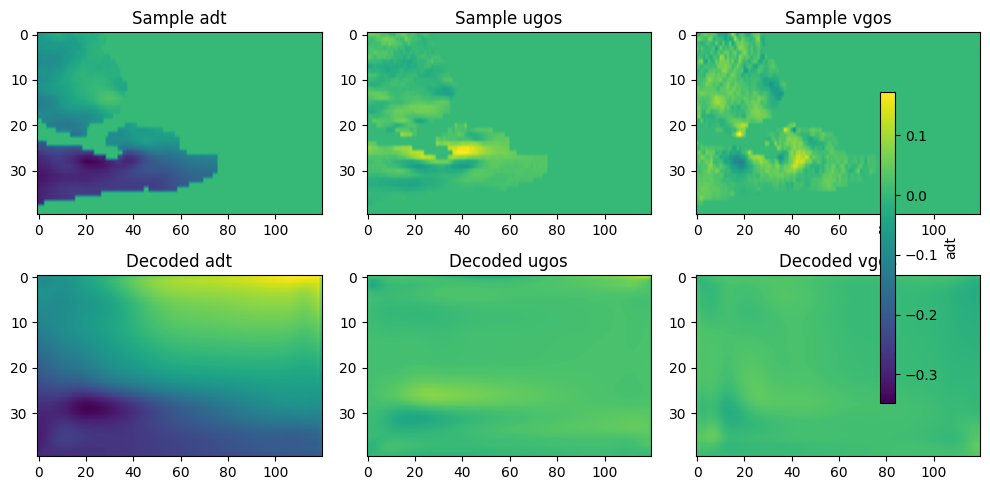

--------------------------------------------------------------------------------------------------


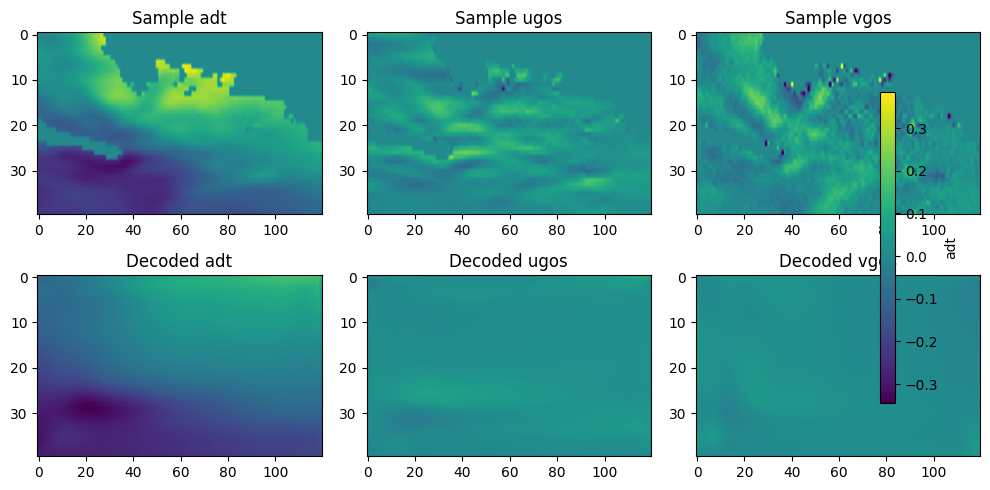

--------------------------------------------------------------------------------------------------


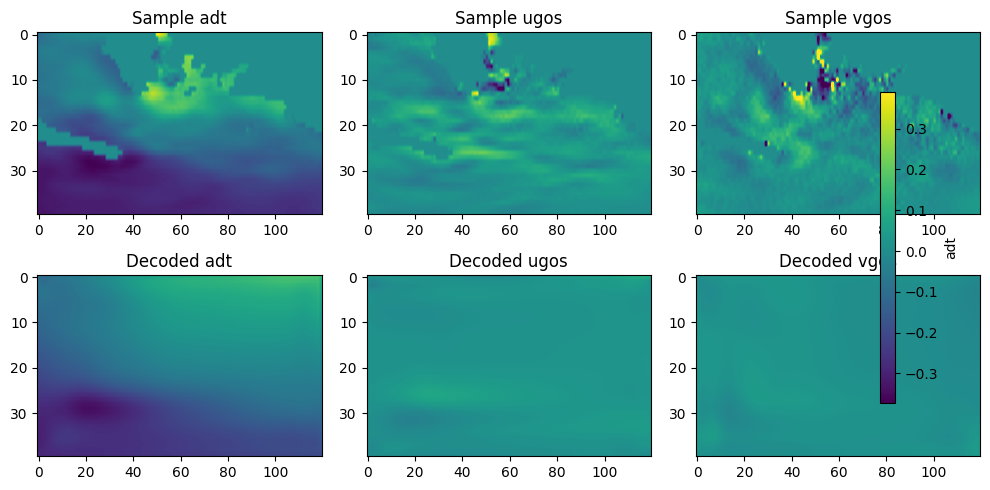

--------------------------------------------------------------------------------------------------


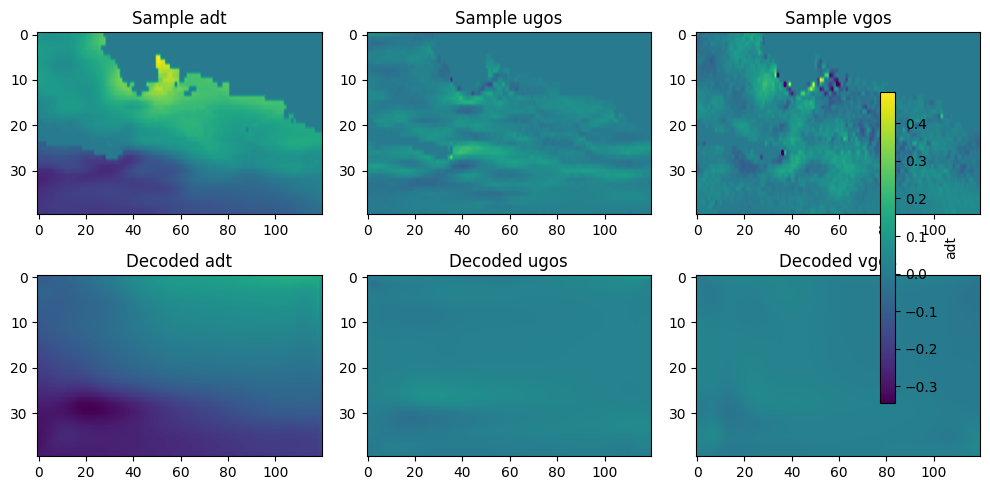

--------------------------------------------------------------------------------------------------


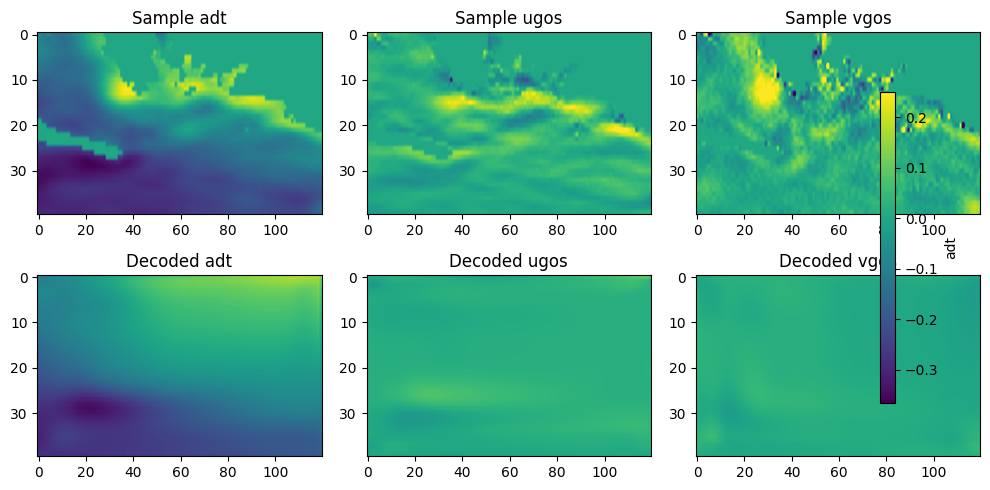

--------------------------------------------------------------------------------------------------


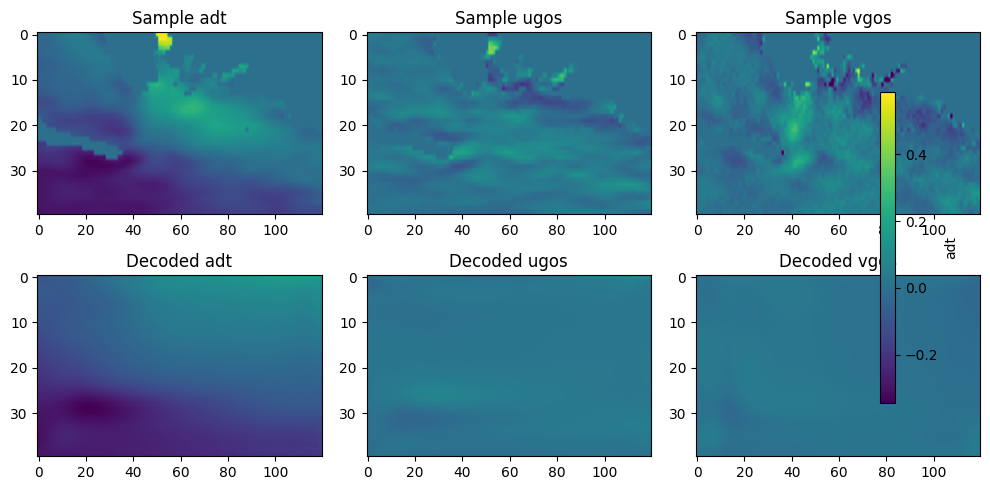

--------------------------------------------------------------------------------------------------


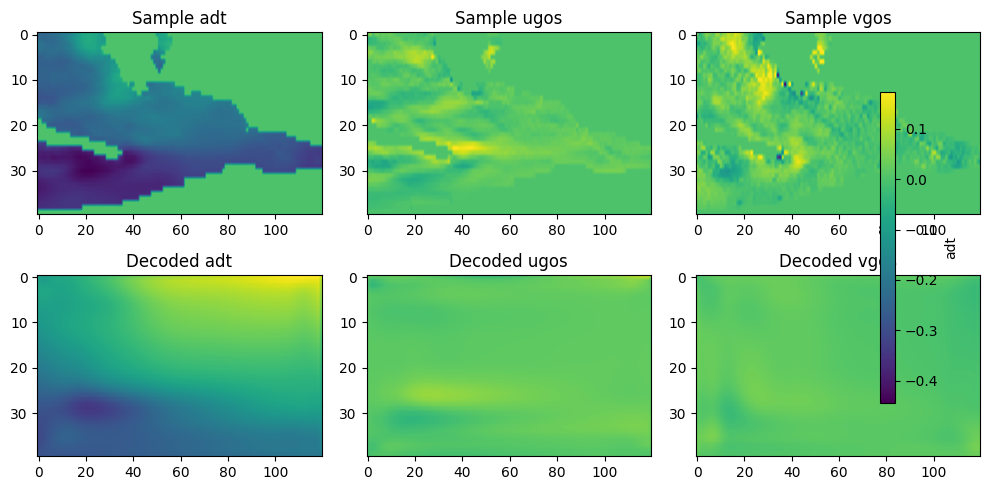

--------------------------------------------------------------------------------------------------


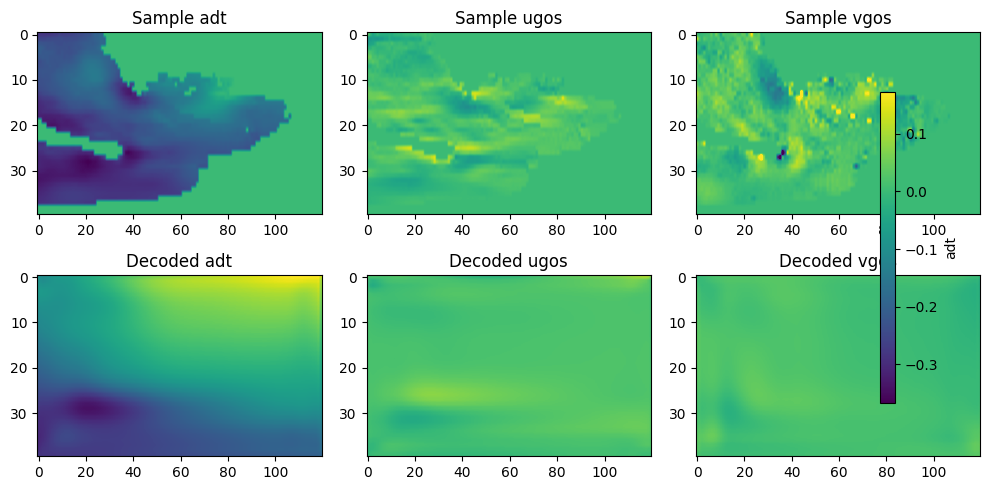

--------------------------------------------------------------------------------------------------


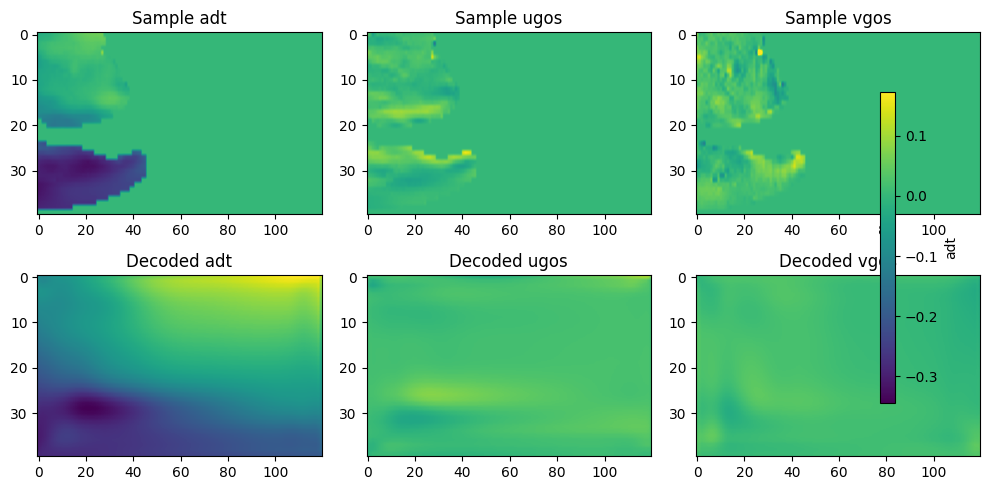

--------------------------------------------------------------------------------------------------


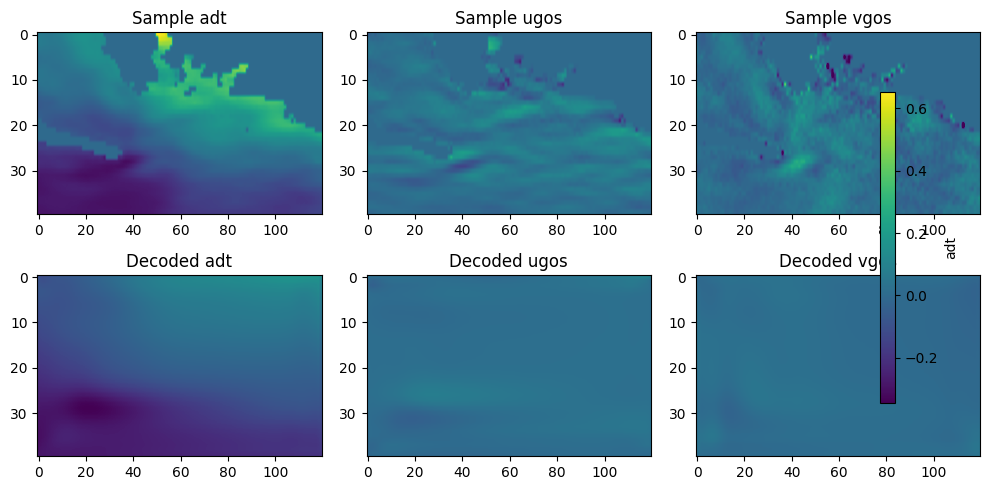

--------------------------------------------------------------------------------------------------


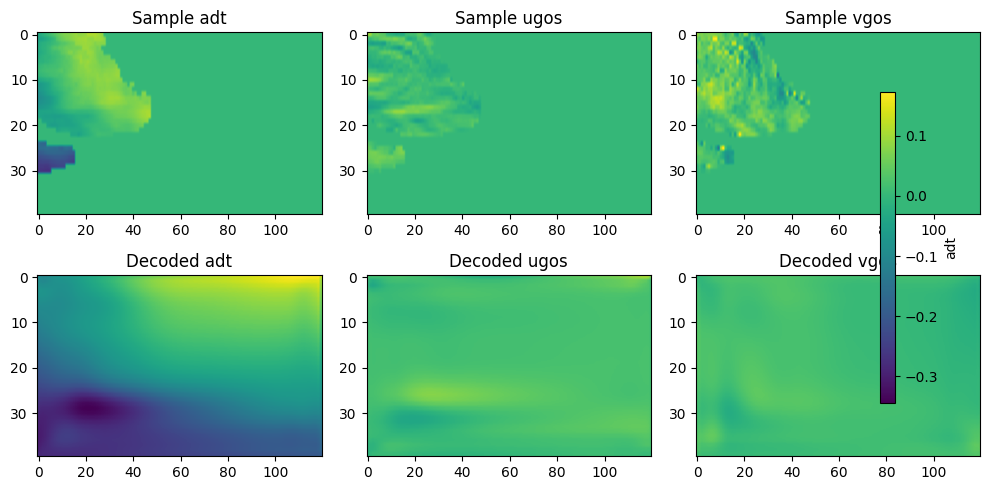

--------------------------------------------------------------------------------------------------


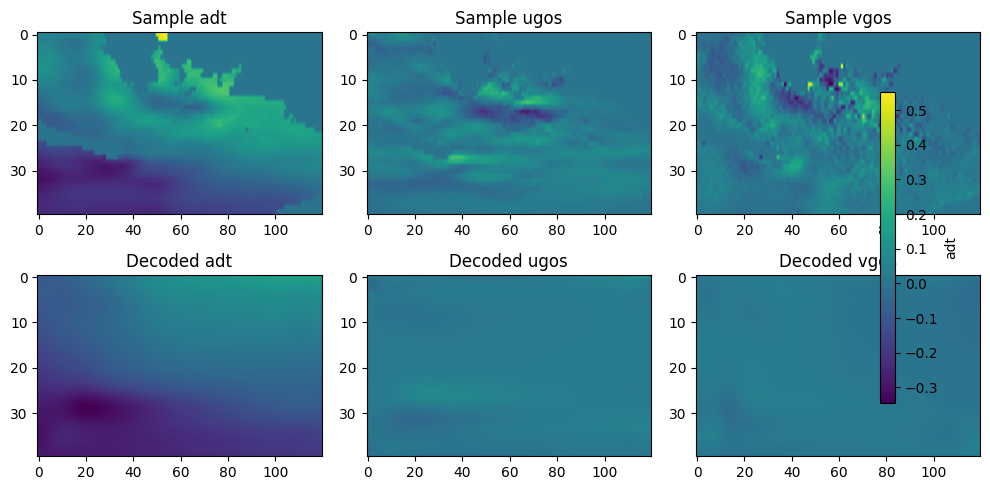

--------------------------------------------------------------------------------------------------


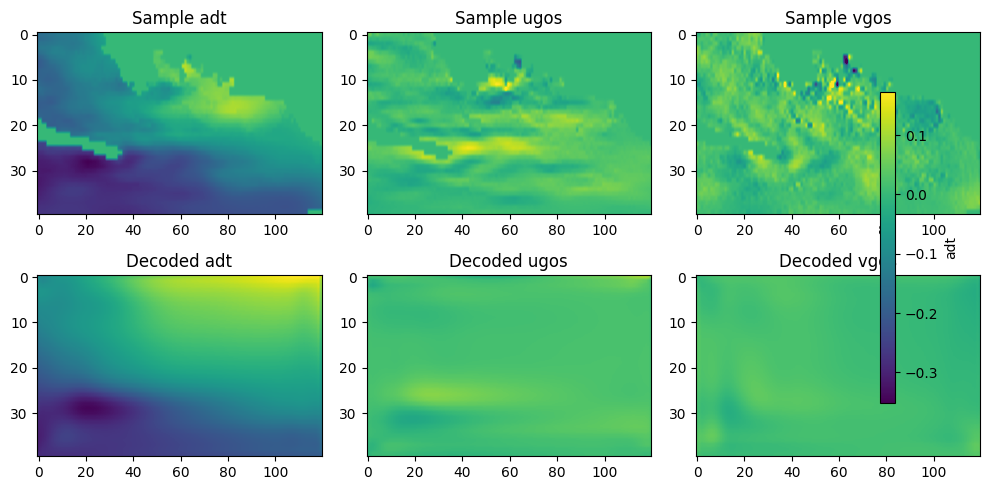

--------------------------------------------------------------------------------------------------


In [16]:
drawing(data_gpu, decoded_data, [i for i in range(data_gpu.shape[0])])